# Banco de Dados Vetoriais: ElasticSearch



### ElasticSearch via Docker

**Pull da última versão**
```
docker pull docker.elastic.co/elasticsearch/elasticsearch:8.12.2
````

**Levantando o container**
```
docker run -d --name elasticsearch -p 9200:9200 -p 9300:9300 -e "discovery.type=single-node" docker.elastic.co/elasticsearch/elasticsearch:8.12.2
```

Talvez seja necessário realizar o login:
```
docker login
```

**Fontes:**
- https://hub.docker.com/_/elasticsearch
- https://elasticsearch-py.readthedocs.io/en/v8.12.1/
- https://elasticsearch-dsl.readthedocs.io/en/latest/

# Preparação para uso

**Acessar o container:**

```
docker exec -it elasticsearch /bin/bash
```

**Exigir as senhas:**

Para gerar e exigir as senhas execute o seguinte comando dentro do container:
```
bin/elasticsearch-setup-passwords auto
```

Copie a senha do usuário 'elastic'.

## Conexão com o ElasticSearch

In [37]:
from elasticsearch import Elasticsearch,  RequestsHttpConnection
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from requests.packages.urllib3 import disable_warnings

# Desabilita avisos de certificado não seguro (não recomendado para produção)
disable_warnings(InsecureRequestWarning)

# Conectar ao Elasticsearch no localhost padrão (porta 9200)
es = Elasticsearch(["https://localhost:9200"],
                   use_ssl=False,
                   verify_certs=False,
                   http_auth=('elastic', 'A0bwVuKDo6d6GZUJ5dfn'),
                   connection_class=RequestsHttpConnection)


/opt/homebrew/Caskroom/miniconda/base/envs/jina/lib/python3.11/site-packages/elasticsearch/connection/http_requests.py:139: UserWarning: Connecting to https://localhost:9200 using SSL with verify_certs=False is insecure.
  warnings.warn(


# Criação do Índice

In [39]:
index_body = {
  "mappings": {
    "properties": {
      "title": {"type": "text"},
      "feature_vector": {"type": "dense_vector", "dims": 3}  # Exemplo com 3 dimensões
    }
  }
}

# Cria o índice se ele não existir
if not es.indices.exists(index="recommendations"):
    es.indices.create(index="recommendations", document=index_body)


# Inserção de Dados

In [49]:
items = [
    {"title": "Item 1", "feature_vector": [1.0, 2.0, 3.0]},
    {"title": "Item 2", "feature_vector": [2.0, 3.0, 4.0]},
    {"title": "Item 3", "feature_vector": [3.0, 4.0, 5.0]},
]

for item in items:
    es.index(index="recommendations", document=item)


# Consulta por similaridade

In [50]:
# Busca por similaridade de cosseno
results = es.search(index="recommendations", query={
    "script_score": {
      "query": {"match_all": {}},
      "script": {
        "source": "cosineSimilarity(params.query_vector, 'feature_vector') + 1.0",
        "params": {"query_vector": [1.5, 2.5, 3.5]}
      }
    }
})

for hit in results['hits']['hits']:
    print(f"ID: {hit['_id']}, Score: {hit['_score']}, Title: {hit['_source']['title']}")


ID: -MYK1o0B9oIvNvHLJseH, Score: 1.9987528, Title: Item 2
ID: 98YK1o0B9oIvNvHLJsd5, Score: 1.9974148, Title: Item 1
ID: -cYK1o0B9oIvNvHLJseS, Score: 1.9934726, Title: Item 3


# Visualização

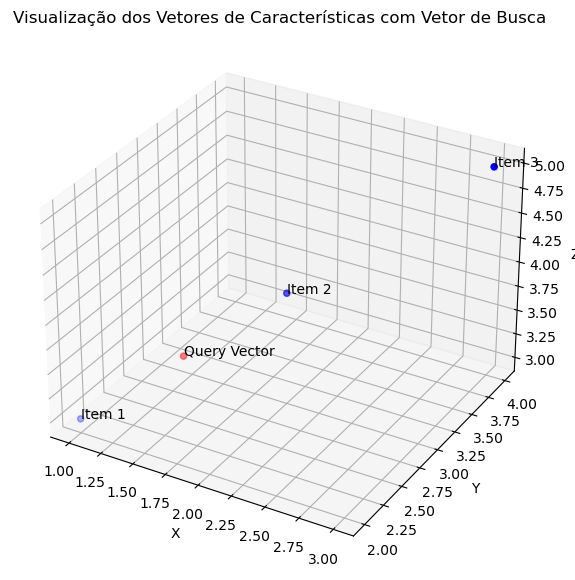

In [42]:
# Gerar o gráfico 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Gerando uma cópia do vetor items 
items_visualizar = items.copy()

# Adicionando o vetor de busca aos dados existentes
items_visualizar.append({"title": "Query Vector", "feature_vector": [1.5, 2.5, 3.5]})

# Preparando os dados para plotagem
x = [item["feature_vector"][0] for item in items_visualizar]
y = [item["feature_vector"][1] for item in items_visualizar]
z = [item["feature_vector"][2] for item in items_visualizar]
titles = [item["title"] for item in items_visualizar]
colors = ['blue' if title != "Query Vector" else 'red' for title in titles]  # Azul para itens, vermelho para o vetor de busca

# Criando o gráfico 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotando os vetores com cores diferentes
scatter = ax.scatter(x, y, z, c=colors)

# Adicionando títulos aos pontos
for i, title in enumerate(titles):
    ax.text(x[i], y[i], z[i], title)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Visualização dos Vetores de Características com Vetor de Busca')
plt.show()


# Excluir os items por consulta

In [47]:
# Exemplo de exclusão por consulta
query = {
  "query": {
    "match": {
      "title": "Item 1"  # Exclui todos os documentos com o título "Item 1"
    }
  }
}

# Excluindo documentos que correspondem à consulta
es.delete_by_query(index="recommendations", body=query)


{'took': 4,
 'timed_out': False,
 'total': 0,
 'deleted': 0,
 'batches': 0,
 'version_conflicts': 0,
 'noops': 0,
 'retries': {'bulk': 0, 'search': 0},
 'throttled_millis': 0,
 'requests_per_second': -1.0,
 'throttled_until_millis': 0,
 'failures': []}